In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time

import mlrose
import pandas as pd
import traitlets.utils.bunch
from mlrose import NNGSRunner
from sklearn.datasets import load_iris
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np


def process_abalone_ternary():
    df = pd.read_csv('data/abalone.data', names=["Sex", "Length", "Diameter", "Height",
                                                 "Whole weight", "Shucked weight", "Viscera weight",
                                                 "Shell weight", "Rings"])
    df = df[(df["Height"] != 1.13) & (df['Height'] != 0.515)]

    # deal with categorical data
    df.loc[df.Sex == 'M', 'Male'] = 1.
    df.loc[df.Sex == 'F', 'Female'] = 1.
    df.loc[df.Sex == 'I', 'Infant'] = 1.
    df.fillna(0, inplace=True)

    # bucketize rings
    df.loc[df.Rings < 11, 'Rings'] = 1.
    df.loc[(df.Rings < 21) & (df.Rings > 10), 'Rings'] = 2.
    df.loc[df.Rings > 20, 'Rings'] = 3.

    return traitlets.Bunch(
        data=df[['Male', 'Female', 'Infant', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
                 'Viscera weight', 'Shell weight']].values,
        target=df[['Rings']].values,
        target_names=df["Rings"].unique(),
        DESCR='abalone dataset...',
        feature_names=['Male', 'Female', 'Infant', "Length", "Diameter", "Height",
                       "Whole weight", "Shucked weight", "Viscera weight",
                       "Shell weight"],
    )

data = process_abalone_ternary()
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, \
                                                    test_size = 0.2, random_state = 3)

# Normalize feature data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()


In [4]:
# Initialize neural network object and fit object
csv_path = 'out/nn_gradient_descent.csv'
cols = ['iter', 'train_accuracy', 'test_accuracy', 'test_f1', 'fit_time', 'loss']
data = []
for i in [1, 50, 100, 200, 400, 800, 1600, 3200]:
    st=time.time()
    nn_modelgd = mlrose.NeuralNetwork(hidden_nodes = [10], activation = 'relu', \
                                     algorithm = 'gradient_descent', max_iters = i, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100, \
                                     random_state = 3, schedule=mlrose.GeomDecay(init_temp=100))

    nn_modelgd.fit(X_train_scaled, y_train_hot)
    fn=time.time()

    from sklearn.metrics import accuracy_score

    # Predict labels for train set and assess accuracy

    y_train_pred = nn_modelgd.predict(X_train_scaled)

    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)


    # Predict labels for test set and assess accuracy
    y_test_pred = nn_modelgd.predict(X_test_scaled)

    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    
    y_test_f1 = f1_score(y_test_hot, y_test_pred, average='macro')

    row = [i, y_train_accuracy, y_test_accuracy, y_test_f1, fn-st, nn_modelgd.loss]
    data.append(row)
    print (row)
    nn_modelgd=[]
result = pd.DataFrame(data, columns=cols)
result.to_csv(csv_path, index=None)

[1, 0.6520958083832336, 0.6586826347305389, 0.2647412755716005, 0.013564348220825195, 0.7223456999870761]
[50, 0.7137724550898203, 0.7077844311377246, 0.42668458781362006, 0.36786317825317383, 0.572367260300249]
[100, 0.7224550898203593, 0.7137724550898203, 0.43667844018945196, 0.7031469345092773, 0.5568555015306643]
[200, 0.7419161676646706, 0.7209580838323353, 0.44360673933758465, 1.371216058731079, 0.5356909757880657]
[400, 0.7452095808383233, 0.7281437125748503, 0.45425868582504697, 2.720177173614502, 0.5283514083241961]
[800, 0.7544910179640718, 0.7592814371257485, 0.492195833149248, 5.478238105773926, 0.5088885976959178]
[1600, 0.7697604790419161, 0.7616766467065869, 0.4895334280085531, 11.104258060455322, 0.49109683787545555]
[3200, 0.7817365269461077, 0.7808383233532934, 0.5038964567960741, 21.931485891342163, 0.4750039791828272]


In [16]:
pd.read_csv(csv_path)

,iter,train_accuracy,test_accuracy,test_f1,fit_time,loss
0,1,0.652096,0.658683,0.264741,0.013564,0.722346
1,50,0.713772,0.707784,0.426685,0.367863,0.572367
2,100,0.722455,0.713772,0.436678,0.703147,0.556856
3,200,0.741916,0.720958,0.443607,1.371216,0.535691
4,400,0.745210,0.728144,0.454259,2.720177,0.528351
5,800,0.754491,0.759281,0.492196,5.478238,0.508889
6,1600,0.769760,0.761677,0.489533,11.104258,0.491097
7,3200,0.781737,0.780838,0.503896,21.931486,0.475004


In [12]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_nn_score_vs_iters(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')


    plt.plot(df['iter'], df['train_accuracy'], 'x-', color="r",
             label="Training Accuracy")
    plt.plot(df['iter'], df['test_accuracy'], 'x-', color="g",
             label="Test Accuracy")
    plt.plot(df['iter'], df['test_f1'], '--', color="g",
             label="Test F1")

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title('Score vs. Iteration for training and test data - ' + alg_name,
              fontsize=14)
    plt.legend()
    plt.savefig(
        'images/' + alg_name + 'nn-score-vs-iteration-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt


def plot_nn_fit_time_vs_iter(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')


    plt.plot(df['iter'], df['fit_time'], 'o-', color="b")

    plt.ylabel('Fit Time', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title(alg_name, fontsize=14)
    plt.savefig('images/' + alg_name + 'nn-fittime-vs-time-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt

def plot_nn_loss_vs_iter(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')

    plt.style.use('seaborn')

    plt.plot(df['iter'], df['loss'], 'o-', color="y")

    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title(alg_name, fontsize=14)
    plt.savefig('images/' + alg_name + 'nn-loss-vs-iteration-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt

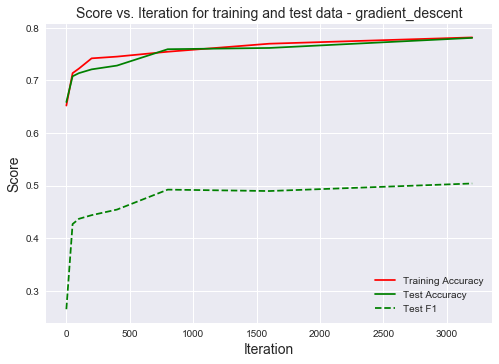

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [13]:
alg_name = 'gradient_descent'
plot_nn_score_vs_iters(alg_name)

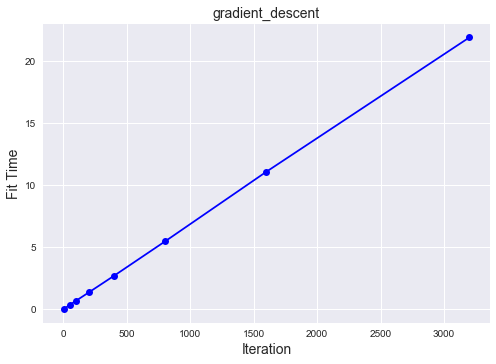

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [14]:
plot_nn_fit_time_vs_iter(alg_name)

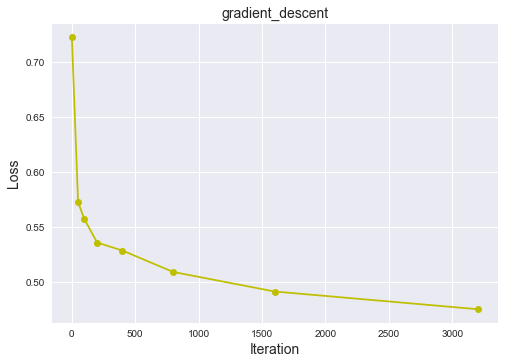

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [15]:
plot_nn_loss_vs_iter(alg_name)